In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

LULC_LAP_FILEPATH = '../data/LULC_LAP_WOH.csv'
LAP_GEOJSON_FILEPATH = '../data/LAP.geojson'
LU_LAP_AGG_FILEPATH = '../data/LAP_landuse_acres.csv'
LU_CODE_METADATA_FILEPATH = '../data/LandUseCodes_DEP.csv'

# LAP EDA

In [7]:
# original lap dataset, includes both WOH and EOH
lap = gpd.read_file(LAP_GEOJSON_FILEPATH, parse_dates=['CLOSING_DT'])
lap = lap[lap.Acquisitio=='LAP']
lap.head(2)

,SWIS_SBL,Acquisitio,REType,PROP_ID,County,Town,CLOSING_DT,SOH,PARC_STAT,GIS_Acres,SubProgram,geometry
642,51400004600500030391000000,LAP,Fee,5,Ulster,Olive,None,West,Active,13.974555,City,"MULTIPOLYGON (((565585.933 4647142.761, 565599..."
643,51400003707300010241100000,LAP,Fee,7,Ulster,Olive,1999-09-08,West,Complete,18.090218,City,"MULTIPOLYGON (((567902.924 4648411.872, 567836..."


In [14]:
lap.groupby('County').GIS_Acres.sum()

County
Delaware       84037.884418
Dutchess        1056.151182
Greene         26460.194101
Putnam          8525.472618
Schoharie       5065.857372
Sullivan        6203.991030
Ulster         21010.719781
Westchester     2003.638013
Name: GIS_Acres, dtype: float64

In [13]:
sorted(lap.CLOSING_DT.dropna().unique())

['1997-10-28',
 '1997-10-29',
 '1998-01-09',
 '1998-02-19',
 '1998-02-24',
 '1998-02-25',
 '1998-03-24',
 '1998-03-25',
 '1998-03-31',
 '1998-04-07',
 '1998-04-08',
 '1998-04-14',
 '1998-04-21',
 '1998-05-19',
 '1998-05-27',
 '1998-06-09',
 '1998-06-10',
 '1998-06-17',
 '1998-07-08',
 '1998-07-14',
 '1998-07-15',
 '1998-07-21',
 '1998-07-22',
 '1998-08-05',
 '1998-08-12',
 '1998-08-18',
 '1998-08-26',
 '1998-08-31',
 '1998-09-01',
 '1998-09-08',
 '1998-09-22',
 '1998-09-23',
 '1998-09-30',
 '1998-10-14',
 '1998-10-20',
 '1998-10-27',
 '1998-11-10',
 '1998-11-24',
 '1998-12-01',
 '1998-12-08',
 '1998-12-09',
 '1998-12-18',
 '1998-12-22',
 '1999-02-10',
 '1999-02-17',
 '1999-02-23',
 '1999-02-24',
 '1999-03-02',
 '1999-03-09',
 '1999-03-10',
 '1999-03-23',
 '1999-04-07',
 '1999-05-18',
 '1999-05-25',
 '1999-05-26',
 '1999-06-08',
 '1999-06-09',
 '1999-07-20',
 '1999-07-21',
 '1999-07-27',
 '1999-08-10',
 '1999-08-11',
 '1999-08-31',
 '1999-09-08',
 '1999-09-10',
 '1999-09-22',
 '1999-10-

In [3]:
print('EOH + WOH:')
print(lap.SWIS_SBL.nunique(), lap.PROP_ID.nunique(), lap.shape, lap.GIS_Acres.sum())
print()
print('WOH only:')
woh = lap[lap.SOH=='West']
print(woh.SWIS_SBL.nunique(), woh.PROP_ID.nunique(), woh.shape, woh.GIS_Acres.sum())

EOH + WOH:
3541 1832 (3551, 12) 237897.696725

WOH only:
2517 1574 (2526, 12) 202195.742233


In [4]:
# sizes of properties - whether EOH, WOH, LAP or non-LAP
lap.groupby('PROP_ID').GIS_Acres.sum().describe()
# average size of plot is 130 acres
# median size of plot is 47 acres
# largest plot is 83k acres

count     1832.000000
mean       129.856821
std       1943.044915
min          0.000000
25%         13.976535
50%         47.178639
75%        116.255800
max      83107.957714
Name: GIS_Acres, dtype: float64

In [5]:
# LAP lands only
print('LAP acreage statistics')
print('EOH + WOH:')
print(lap[lap.Acquisitio=='LAP'].groupby('PROP_ID').GIS_Acres.sum().describe())
print()
print('WOH only:')
print(lap[(lap.Acquisitio=='LAP') & (lap.SOH=='West')].groupby('PROP_ID').GIS_Acres.sum().describe())
print()
print('EOH only:')
print(lap[(lap.Acquisitio=='LAP') & (lap.SOH=='East')].groupby('PROP_ID').GIS_Acres.sum().describe())

LAP acreage statistics
EOH + WOH:
count    1813.000000
mean       85.142807
std       114.078631
min         0.051802
25%        14.397746
50%        47.658099
75%       116.490930
max      1535.307079
Name: GIS_Acres, dtype: float64

WOH only:
count    1560.000000
mean       91.524774
std       116.404221
min         0.051802
25%        18.711440
50%        54.430985
75%       123.382526
max      1535.307079
Name: GIS_Acres, dtype: float64

EOH only:
count    253.000000
mean      45.791549
std       89.122124
min        0.387456
25%        2.953939
50%       10.984845
75%       45.806307
max      873.589479
Name: GIS_Acres, dtype: float64


# LULC-inner joined-LAP EDA

In [29]:
# LAP inner joined with LULC, only kept most of WOH properties 
lulc_lap = pd.read_csv(LULC_LAP_FILEPATH, parse_dates=['closing_date'])
lulc_lap = lulc_lap[lulc_lap.acquisition_method=='LAP'] # use only those acquired under LAP
lulc_lap.head()

,FID_LAP,FID_LU,SWIS_SBL,PROP_ID,landuse_code,landuse_acres,property_acres,acquisition_method,subprogram,real_estate_type,county,town,closing_date,side_of_hudson,parcel_status
43,1314,109131,1.254E+25,1371,3000,0.024373,50.197865,LAP,City,Fee,Delaware,Tompkins,2004-06-23,West,Complete
63,3061,109265,1.25689E+25,6247,3000,0.025090,15.739428,LAP,WAC,WAC FE,Delaware,Walton,2019-01-14,West,Complete
66,3064,109278,1.25689E+25,6247,3000,0.637695,33.958630,LAP,WAC,WAC FE,Delaware,Walton,2019-01-14,West,Complete
123,1448,109989,1.254E+25,1757,4200,1.194196,14.856476,LAP,City,Fee,Delaware,Tompkins,2001-05-22,West,Complete
134,1316,110013,1.254E+25,1392,4200,0.659229,5.316318,LAP,City,Fee,Delaware,Tompkins,2001-08-07,West,Complete


In [30]:
print('LULC-inner joined-LAP:')
print(lulc_lap.SWIS_SBL.nunique(), lulc_lap.PROP_ID.nunique(), lulc_lap.shape, lulc_lap.property_acres.sum())

LULC-inner joined-LAP:
44 1560 (28564, 15) 3230653.38666368


In [31]:
# percent acreage that LULC_LAP accounts for in WOH
lulc_lap_acres = lulc_lap.landuse_acres.sum()
lulc_lap_prop_acres = lulc_lap[['FID_LAP', 'property_acres']].drop_duplicates().property_acres.sum()
lulc_lap_acres/lulc_lap_prop_acres

1.0002210035653274

In [32]:
# percent WOH PROP_IDs accounted for in LULC_LAP - specifically those under LAP
lulc_lap_ids = set(lulc_lap.PROP_ID)
woh_ids = set(woh[woh.Acquisitio=='LAP'].PROP_ID)

len(lulc_lap_ids.intersection(woh_ids)) / len(woh_ids)

1.0

# Aggregate landuse acres per annum

In [36]:
lu_agg = lulc_lap.pivot_table(index=lulc_lap.closing_date.dt.year, 
                     columns='landuse_code',
                     values='landuse_acres',
                     aggfunc='sum',
                     fill_value=0)

lu_agg.index = lu_agg.index.astype('int') # convert year from float to int
lu_agg = lu_agg.drop(index=2020)          # drop 2020 since it is an incomplete year
lu_agg

landuse_code,1110,1120,1130,1140,1190,1210,1220,1230,1240,1250,...,2210,2220,2400,2410,3000,4100,4200,4300,5000,7500
closing_date,,,,,,,,,,,,,,,,,,,,,
1997,0.519640,0.108184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.581531,0.000000,107.852625,4.078944,0.000000,0.000000
1998,8.254754,2.174211,0.000000,0.000000,4.348938,0.674090,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,70.111390,1314.104127,834.018025,892.572934,0.004101,0.000000
1999,6.250232,3.230033,1.366382,0.000000,1.535344,0.855467,0.187760,0.885944,0.000000,0.299695,...,0.000000,0.000000,0.000000,0.000000,54.817533,785.142218,706.738948,765.026117,2.799961,0.256604
2000,12.239751,3.135114,0.000000,0.000000,8.018274,0.655104,0.426699,0.005652,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,127.480096,1160.838485,992.400704,640.803387,0.618687,0.000000
2001,19.945249,4.534066,0.296129,0.000000,30.651458,0.956053,0.011031,0.001869,0.000000,0.000000,...,0.000000,0.000000,11.554088,0.000000,261.848607,1924.585100,1204.796814,1163.812101,8.232890,0.000000
2002,46.496059,12.939957,1.613887,0.000000,72.812505,3.757494,0.028119,0.000000,0.000000,0.000000,...,0.000000,1.404444,37.104631,1.287388,782.740588,3570.080596,1522.701339,1313.079097,15.971899,1.263688
2003,24.481180,12.126767,0.000000,0.000000,113.263529,2.620543,0.032493,0.000000,0.000000,0.001051,...,0.000000,0.000000,0.000000,0.000000,738.160071,3319.579019,1892.932865,1833.211495,62.537884,0.053629
2004,34.402625,15.688459,0.000000,0.000000,45.685596,3.990985,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.031664,53.987294,20.004134,402.776695,3014.524508,1648.051317,1268.315298,25.981071,0.989677
2005,38.976577,16.626013,2.257768,0.002232,49.727882,2.083421,0.325337,0.212753,0.000000,0.000000,...,0.000000,0.000000,50.775199,1.429020,415.348432,4168.493420,1341.061792,1427.899141,39.451089,0.000000


Text(0, 0.5, 'Landuse code')

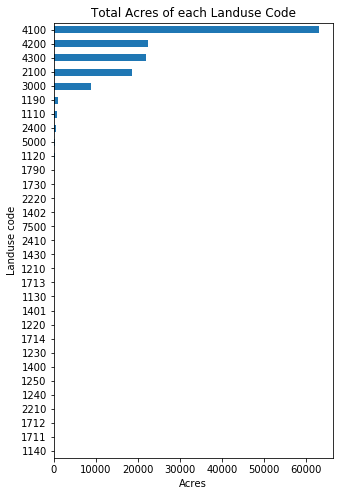

In [37]:
lu_agg.sum().sort_values(ascending=True).plot.barh(figsize=(5,8), 
                                                   title='Total Acres of each Landuse Code')
plt.xlabel('Acres')
plt.ylabel('Landuse code')

In [39]:
lu_agg.to_csv(LU_LAP_AGG_FILEPATH)

# Merge minor landuse codes into 'Others'

In [40]:
# total acres of each land use
landuse_codes_to_merge = lu_agg.sum().sort_values(ascending=False)[8:].index
landuse_codes_to_merge

Int64Index([5000, 1120, 1790, 1730, 2220, 1402, 7500, 2410, 1430, 1210, 1713,
            1130, 1401, 1220, 1714, 1230, 1400, 1250, 1240, 2210, 1712, 1711,
            1140],
           dtype='int64', name='landuse_code')

In [41]:
lu_agg['Others'] = lu_agg[landuse_codes_to_merge].sum(axis=1)
lu_agg = lu_agg.drop(columns=landuse_codes_to_merge)
lu_agg.head()

landuse_code,1110,1190,2100,2400,3000,4100,4200,4300,Others
closing_date,,,,,,,,,
1997,0.519640,0.000000,0.000000,0.000000,0.581531,0.000000,107.852625,4.078944,0.108184
1998,8.254754,4.348938,0.407138,0.000000,70.111390,1314.104127,834.018025,892.572934,13.111812
1999,6.250232,1.535344,27.714003,0.000000,54.817533,785.142218,706.738948,765.026117,15.050097
2000,12.239751,8.018274,86.708310,0.000000,127.480096,1160.838485,992.400704,640.803387,10.396127
2001,19.945249,30.651458,502.707319,11.554088,261.848607,1924.585100,1204.796814,1163.812101,24.669625


In [48]:
lu_desc = pd.read_csv(LU_CODE_METADATA_FILEPATH, index_col=0)
lu_desc[lu_desc.LU_Code.isin(lu_agg.columns)]

,LU_Code,Description,LU_Class_Short,AndLvl1,AndLvl1Des,AndLvl2,AndLvl2Des,AndLvl3,AndLvl3Des
OBJECTID,,,,,,,,,
1,1110,Residential - Very Low Density,Residential - Very Low Density,1,Urban or Built-up Land,11,Residential,111,Residential - Very Low Density
5,1190,Vacant Land - Vegetated,Other Vegetation,1,Urban or Built-up Land,11,Residential,119,Vacant Land - Vegetated
23,2100,Agricultural Cropland/Pasture,Agriculture,2,Agricultural Land,21,Cropland and Pasture,210,Cropland and Pasture
26,2400,Farmstead,Farmsteads,2,Agricultural Land,24,Farmstead (Including infrastructure),240,Farmstead
28,3000,Brushland or Successional Land,Brushland,3,Brushland or Successional Forest,30,Brushland or Successional Forest,300,Brushland or Successional Forest
29,4100,Deciduous Forest Land,Forest - Deciduous,4,Forest Land,41,Deciduous Forest Land,410,Deciduous Forest Land
30,4200,Coniferous Forest Land,Forest - Coniferous,4,Forest Land,42,Coniferous Forest Land,420,Coniferous Forest Land
31,4300,Forest - Mixed,Forest - Mixed,4,Forest Land,43,Mixed Forest Land,430,Mixed Forest Land


In [56]:
LANDUSE_MAPPING = {1110: 'Urban/Built-up Land',
                   1190: 'Urban/Built-up Land',
                   2100: 'Agricultural Land',
                   2400: 'Agricultural Land',
                   3000: 'Forest Land',
                   4100: 'Forest Land',
                   4200: 'Forest Land',
                   4300: 'Forest Land',
                   5000: 'Others', 1120: 'Others', 1790: 'Others', 
                   1730: 'Others', 2220: 'Others', 1402: 'Others',
                   7500: 'Others', 2410: 'Others', 1430: 'Others',
                   1210: 'Others', 1713: 'Others', 1130: 'Others',
                   1401: 'Others', 1220: 'Others', 1714: 'Others',
                   1230: 'Others', 1400: 'Others', 1250: 'Others',
                   1240: 'Others', 2210: 'Others', 1712: 'Others',
                   1711: 'Others', 1140: 'Others'
}

In [60]:
lulc_lap['landuse'] = lulc_lap.landuse_code.replace(LANDUSE_MAPPING)
lu_agg = lulc_lap.pivot_table(index=lulc_lap.closing_date.dt.year, 
                     columns='landuse',
                     values='landuse_acres',
                     aggfunc='sum',
                     fill_value=0)
lu_agg.index = lu_agg.index.astype('int')
lu_agg = lu_agg.drop(index=2020)
lu_agg

landuse,Agricultural Land,Forest Land,Others,Urban/Built-up Land
closing_date,,,,
1997,0.000000,112.513101,0.108184,0.519640
1998,0.407138,3110.806476,13.111812,12.603692
1999,27.714003,2311.724817,15.050097,7.785575
2000,86.708310,2921.522672,10.396127,20.258026
2001,514.261408,4555.042621,24.669625,50.596707
2002,1154.303153,7188.601620,55.308488,119.308563
2003,256.200084,7783.883449,119.036296,137.744709
2004,2189.877108,6333.667817,79.467623,80.088221
2005,1534.291717,7352.802785,67.420287,88.704459


Text(0, 0.5, 'Acres')

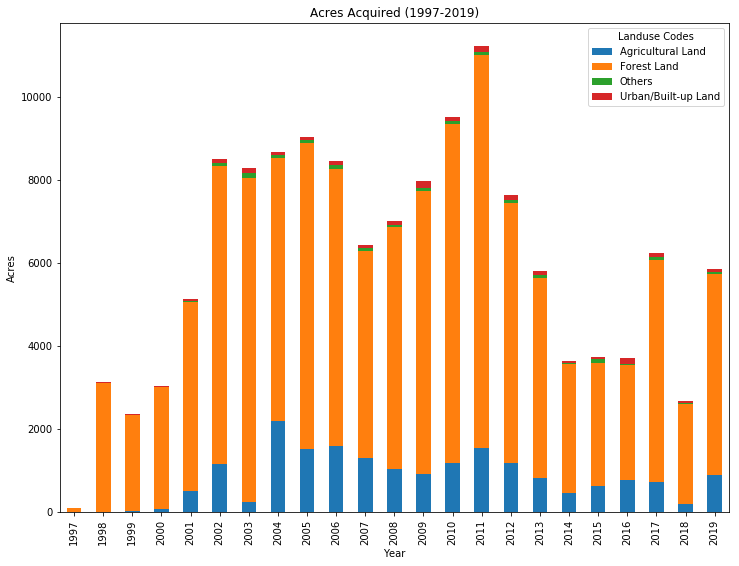

In [69]:
lu_agg.plot.bar(figsize=(12,9), 
                 stacked=True, 
#                  cmap='tab10', 
                 legend='reverse',
                 title='Acres Acquired (1997-2019)',
                 xticks=lu_agg.index)
plt.legend(title='Landuse Codes')
plt.xlabel('Year')
plt.ylabel('Acres')

# Export as csv

In [86]:
lulc_lap = lulc_lap.sort_values(['PROP_ID', 'closing_date'])\
    .reset_index(drop=True)
lulc_lap.head()

,FID_LAP,FID_LU,SWIS_SBL,PROP_ID,landuse_code,landuse_acres,property_acres,acquisition_method,subprogram,real_estate_type,county,town,closing_date,side_of_hudson,parcel_status,landuse
0,642,106350,5.14E+25,5,1220,0.143731,13.974555,LAP,City,Fee,Ulster,Olive,NaT,West,Active,Others
1,642,106719,5.14E+25,5,4200,5.968638,13.974555,LAP,City,Fee,Ulster,Olive,NaT,West,Active,Forest Land
2,642,107221,5.14E+25,5,4100,1.534900,13.974555,LAP,City,Fee,Ulster,Olive,NaT,West,Active,Forest Land
3,642,107895,5.14E+25,5,4300,4.055936,13.974555,LAP,City,Fee,Ulster,Olive,NaT,West,Active,Forest Land
4,642,107910,5.14E+25,5,4300,1.163865,13.974555,LAP,City,Fee,Ulster,Olive,NaT,West,Active,Forest Land


In [95]:
lulc_lap = lulc_lap.dropna(subset=['closing_date'])
lulc_lap['year'] = lulc_lap.closing_date.dt.year
lulc_lap['year'] = lulc_lap.year.astype('int')
lulc_lap.head(20)

/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,FID_LAP,FID_LU,SWIS_SBL,PROP_ID,landuse_code,landuse_acres,property_acres,acquisition_method,subprogram,real_estate_type,county,town,closing_date,side_of_hudson,parcel_status,landuse,year
8,643,106257,5.14E+25,7,3000,4.607891,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Forest Land,1999
9,643,106333,5.14E+25,7,1210,0.096011,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Others,1999
10,643,106334,5.14E+25,7,1210,0.008777,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Others,1999
11,643,106818,5.14E+25,7,4200,2.485314,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Forest Land,1999
12,643,106821,5.14E+25,7,4200,0.494484,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Forest Land,1999
13,643,107401,5.14E+25,7,4100,4.909811,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Forest Land,1999
14,643,108050,5.14E+25,7,4300,2.283020,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Forest Land,1999
15,643,108058,5.14E+25,7,4300,2.052945,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Forest Land,1999
16,643,108089,5.14E+25,7,4300,0.177794,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Forest Land,1999
17,643,108158,5.14E+25,7,1250,0.299695,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Others,1999


In [100]:
lulc_lap = lulc_lap.reset_index(drop=True)

In [101]:
lulc_lap.shape

(27599, 17)

In [102]:
lulc_lap.to_csv(LU_LAP_AGG_FILEPATH)

In [15]:
# eda for report 
LAP_ACRES_FILEPATH = '../data/LAP_landuse_acres.csv'
df = pd.read_csv(LAP_ACRES_FILEPATH, index_col=0)
df.head()

,FID_LAP,FID_LU,SWIS_SBL,PROP_ID,landuse_code,landuse_acres,property_acres,acquisition_method,subprogram,real_estate_type,county,town,closing_date,side_of_hudson,parcel_status,landuse,year
0,643,106257,5.14E+25,7,3000,4.607891,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Forest Land,1999
1,643,106333,5.14E+25,7,1210,0.096011,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Others,1999
2,643,106334,5.14E+25,7,1210,0.008777,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Others,1999
3,643,106818,5.14E+25,7,4200,2.485314,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Forest Land,1999
4,643,106821,5.14E+25,7,4200,0.494484,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Forest Land,1999


In [19]:
landuse_dist = df.groupby('landuse').landuse_acres.sum().sort_values()
landuse_dist/landuse_dist.sum()

landuse
Others                 0.008274
Urban/Built-up Land    0.013583
Agricultural Land      0.137983
Forest Land            0.840160
Name: landuse_acres, dtype: float64

# Export as json

In [5]:
import pandas as pd
LAP_ACRES_FILEPATH = '../data/LAP_landuse_acres.csv'
WOH_COUNTIES = ['Delaware', 'Greene', 'Schoharie',
                'Sullivan', 'Ulster']

df = pd.read_csv(LAP_ACRES_FILEPATH, index_col=0)
df.head()

,FID_LAP,FID_LU,SWIS_SBL,PROP_ID,landuse_code,landuse_acres,property_acres,acquisition_method,subprogram,real_estate_type,county,town,closing_date,side_of_hudson,parcel_status,landuse,year
0,643,106257,5.14E+25,7,3000,4.607891,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Forest Land,1999
1,643,106333,5.14E+25,7,1210,0.096011,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Others,1999
2,643,106334,5.14E+25,7,1210,0.008777,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Others,1999
3,643,106818,5.14E+25,7,4200,2.485314,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Forest Land,1999
4,643,106821,5.14E+25,7,4200,0.494484,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Forest Land,1999


In [8]:
data = {}
county = 'Delaware'
landuse_type = 'Forest Land'
for county in WOH_COUNTIES:
    data[county] = df[(df.county==county)].pivot_table(columns='landuse', 
                                                       index='year', 
                                                       values='landuse_acres', 
                                                       aggfunc='sum', 
                                                       fill_value=0).to_dict()


In [14]:
import json
with open('../output/lap_woh_with_landuse.json', 'w') as f:
    json.dump(data, f)

In [16]:
# aggregate by landuse first
with open('../output/lap_landuse_acres_sum.json', 'w') as f:
    data = df.pivot_table(index='year', 
                   columns='landuse',
                   values='landuse_acres', 
                   aggfunc='sum',fill_value=0).to_dict()
    json.dump(data, f, indent=2)